## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [1]:
# First we import our libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Then we read the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Find the nummber of rows and columns in the dataset.
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
# Find the number of unique values in the dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
# Find the proportion of users that converted from using the old landing page to the new landing page.
(df.converted == 1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("landing_page == 'new_page' and group != 'treatment'").count()[0] + df.query("landing_page != 'new_page' and group == 'treatment'").count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
# To find out if there are missing values the rows of the dataset
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
# Create a new and more acceptable dataset where "new_page" and "treatment" match.
df_new = df.query("landing_page == 'new_page' and group == 'treatment'")
df_old = df.query("landing_page == 'old_page' and group == 'control'")

df2 = pd.concat([df_new, df_old])
df2.tail()

,user_id,timestamp,group,landing_page,converted
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
# Check the number of unique users in the new dataset.
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# Information about the one non-unique user.
duplicateRow = df2[df2.duplicated(['user_id'])]
print(duplicateRow)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


c. What is the row information for the repeat **user_id**? 

In [12]:
print(df.loc[[2893]].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2893 to 2893
Data columns (total 5 columns):
user_id         1 non-null int64
timestamp       1 non-null object
group           1 non-null object
landing_page    1 non-null object
converted       1 non-null int64
dtypes: int64(2), object(3)
memory usage: 48.0+ bytes
None


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Remove the non-unique user row.
df2 = df2.drop(2893, axis = 0)

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# Probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# Probability that an individual in the control group converted
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# Probability that an individual in the treatment group converted
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
# Probability that an individual recieved the new landing page.
len(df2[df2['landing_page'] == 'new_page']) / len(df2)

0.5000619442226688

# There is no sufficient evidence to conclude that the new treatment page leads to more conversions because the proportion of people in the control group that converted is 12.03% and the proportion of people in the treatment group that converted is 11.88%. There is not much difference between the two proportions, so we cannot say for sure that one leads to more conversions. We need to undergo further testing.

<a id='ab_test'></a>
### Part II - A/B Test  

# null = 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 ≥ 0
# alternate = 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 < 0

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
# Conversion rate for Pnew under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
# Conversion rate for Pold under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
# The number of individuals in the treatment group
n_new = df2.query("group == 'treatment'").count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
# The number of individuals in the control group
n_old = df2.query("group == 'control'").count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# Pnew - Pold
new_page_converted.mean() - old_page_converted.mean()

1.2340516767489484e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted
p_diffs

array([  8.58400937e-04,  -1.08935216e-03,   1.25771642e-03, ...,
         4.61000870e-05,   1.51881019e-03,  -1.07576754e-03])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

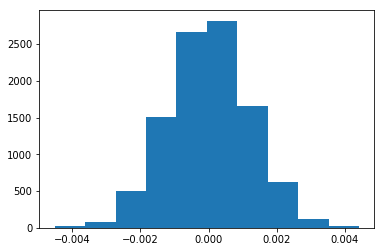

In [26]:
plt.hist(p_diffs);

# The plot is a normal distribution, as i expected.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# Difference between the proportion of people in the treatment group that converted and the proportion of people in the control group that converted
actual_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()
actual_diff

-0.0015782389853555567

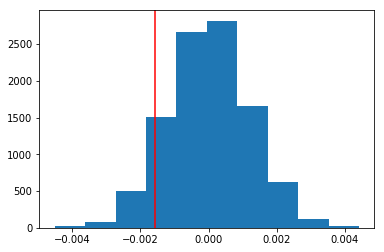

In [28]:
plt.hist(p_diffs);
plt.axvline(actual_diff, color = 'red');

In [29]:
p_diffs = np.array(p_diffs)
p_val = (p_diffs > actual_diff).mean()
p_val

0.91080000000000005

# I just computed the proportion of p_diffs greater than the actual difference. In scientific studies, this is called the "p-value". I obtained a value of 0.9028, which is greater than 0.05. Therefore, we cannot reject the null hypothesis. This means that the new page is not better than the old page. There is no difference between the two pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

# Number of conversions for each page
convert_old = df2.query("landing_page == 'old_page' and converted == 1").count()[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").count()[0]

# Number of individuals who recieved each page
n_old = df2.query("landing_page == 'old_page'").count()[0]
n_new = df2.query("landing_page == 'new_page'").count()[0]
p1_hat = convert_new / n_new
p2_hat = convert_old / n_old
p = (convert_old + convert_new) / (n_old + n_new)
z_stat = (p2_hat - p1_hat) / np.sqrt(p*(1-p) * ((1 / n_old) + (1 / n_new)))
z_stat

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


1.3109241984234394

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([n_new, n_old])
nobs = np.array([convert_new, convert_old])
value = 0.05
stat, pval = proportions_ztest(count, nobs, value = value)

/opt/conda/lib/python3.6/site-packages/statsmodels/stats/proportion.py:806: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)
/opt/conda/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:672: RuntimeWarning: invalid value encountered in absolute
  pvalue = stats.norm.sf(np.abs(zstat))*2


In [32]:
# Critical value
from scipy.stats import norm
norm.ppf(1 - value)

1.6448536269514722

# The p-value is 0.903 and z-score is approximately 1.31. As calculated above, the critical value is 1.64, which is greater than the z-score. Therefore, we cannot reject the null hypothesis. There is no difference between the old page and the new page. The conclusion is the same as above.

<a id='regression'></a>
### Part III - A regression approach 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

# Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# Create a dummy variable column for which page each user received.
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop', axis = 1, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
result = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        08:15:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with the ab_page is 0.190. It differs from the value found in part II because they have different hypothesis.

Part II Hypothesis:

                    Hnull : Pold ≥ Pnew
                    
                    Halternate: Pold < Pnew
Part III Hypothesis:

                    Hnull: Pold = Pnew
                    
                    Halternate: Pold  ≠ Pnew

# It is a good idea to consider other factors to add to my regression model because many different factors may affect the result. It they are not considered, the result may not be correct. 

# There are some disadventages of adding additional terms into my regression model. One of them is multicollinearility, where one factor is related to another.

# Now we're going to consider the factor of the country where the user lives.

In [36]:
# Read the countries dataset
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Merge the countries dataset with the df2 dataset
complete_df = df2.merge(country_df, on = 'user_id', how = 'inner')
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [38]:
complete_df = complete_df.join(pd.get_dummies(complete_df['country']))
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [39]:
result = sm.Logit(complete_df['converted'], complete_df[['intercept', 'ab_page', 'CA', 'UK']]).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        08:15:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

The p-values above are all greater than 0.05, so we do not reject the null hypothesis. Even if we take country as a factor into account, the result remains the same.

# We would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [40]:
# Create a column that combines the group column and the country column
complete_df['group_country'] = complete_df['group'] + '_' + complete_df['country']
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,group_country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,treatment_US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,treatment_US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,treatment_UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA


In [41]:
complete_df = complete_df.join(pd.get_dummies(complete_df['group_country']))
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,group_country,control_CA,control_UK,control_US,treatment_CA,treatment_UK,treatment_US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,treatment_US,0,0,0,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,treatment_US,0,0,0,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA,0,0,0,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,treatment_UK,0,0,0,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA,0,0,0,1,0,0


In [42]:
result = sm.Logit(complete_df['converted'], complete_df[['intercept', 'ab_page', 'CA', 'UK', 'treatment_CA', 'treatment_UK']]).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        08:15:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page         -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA              -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK              -0.0057      0.019     -0.306      0.760      -0.043       0.031
treatment_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
treatment_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
================================================================================
"""

# All the p-values above are greater than the critical value, so there is no significant effect on the result.

# Conclusion

In this experiment, it was our aim to find out if the landing page significantly affected the conversion rate. Hence we had our null hypothesis which stated that the old landing page has the same or even higher converted rate than the new landing page. And we had our alternate hypothesis which stated that the new landing page had a higher converted rate than the old landing page.

In order to get the result, we performed an A/B test by using two methods:

1) Simulating from the null

2) Calculating the z-score.

Both methods gave the same result and conclusion of not rejecting the null hypothesis: There is no significant effect of the landing page on the converted rate.

We also tried the regression method by using a logistic regression model. The p-value was different from what we obtained in the A/B test because of the difference in the null and alternate hypothesis. However, it gave a similar result to that from the A/B test.

Finally, in order to avoid the situation in Simpson's paradox, we introduced an additonal factor into the regression model. The factor introduced was the country a user lives. We looked at the individual factors and the interation of country and landing_page to see if they have significant effects on conversion. The results showed that the factors of landing page and country have no significant effect on the converted rate individually, as well as interactively.

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0